## Table of Contents

1. [Literature review](#lit)
1. [Portfolio](#port)
1. [Exploratory data analysis](#eda)
1. [Historical method](#histmeth)
    1. [Value at risk](#var)
    1. [Expected shortfall](#es)
1. [Data](#data)

1. [Backtest](#backtest)
1. [Monte Carlo Simulation](#montecarlo)
1. [Parametric](#parametric)
1. [Exponentially weighted moving average](#EMWA)
1. [Autoregressive conditional heteroskedasticity](#ARCH)
1. [General autoregressive conditional heteroskedasticity](#GARCH)
1. [Exponential general autoregressive conditional heteroskedasticity](#EGARCH)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import collections
from pandas_datareader import data as pdr
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import efficient_frontier
pd. set_option('display.max_rows', None)

"""
This is a dictionary of some portfolios and tickers of its constituents
"""
tickers = {
         #  Tickers of the constituents of ftse100 as a list.
         #  https://www.londonstockexchange.com/indices/ftse-100/constituents/table
         #  Changes due to lack of historical record:
         #  [PSN:JMAT.L, PSH.L:LIN, AAF.L:INVR.L, MNG.L:AON, AVST.L:PNR, HLN.L:ITV.L, HBR.L:RMG.L]
    'ftse100':['HWDN.L', 'III', 'SPX.L', 'ICP.L', 'ITV.L', 'HLMA.L', 
               'TW.L', 'ITRK.L', 'EXPN.L', 'RS1.L', 'BDEV.L', 'CRDA.L', 
               'JMAT.L', 'AUTO', 'STJ.L', 'RMV.L', 'HL.L', 'SN.L', 
               'HIK.L', 'AVV.L', 'JD.L', 'BKG.L', 'WPP', 'BNZL.L', 
               'SGE.L', 'ABDN.L', 'SMIN', 'LGEN.L', 'SDR.L', 'AHT', 
               'REL.L', 'SMT.L', 'SGRO.L', 'LAND', 'SKG.L', 'BRBY.L', 
               'LSEG.L', 'NXT.L', 'AV.L', 'HSBA.L', 'DGE.L', 'BME', 
               'UTG', 'AAL', 'PHNX.L', 'BARC.L', 'BT-A.L', 'ABF.L', 
               'LIN', 'MNDI.L', 'NWG', 'CCH.L', 'RTO.L', 'KGF.L', 
               'PSON.L', 'CRH', 'TSCO', 'SVT', 'INVR.L', 'BLND.L', 
               'STAN.L', 'SMDS.L', 'AON', 'RR.L', 'INF.L', 'UU.L', 
               'IMB.L', 'VOD', 'SBRY.L', 'RIO', 'FLTR', 'EDV', 'MRO', 
               'ULVR.L', 'DCC.L', 'CPG', 'ANTO.L', 'ADM', 'MGGT.L', 
               'LLOY.L', 'PRU', 'ENT.L', 'BATS.L', 'RKT.L', 'CNA', 
               'FRES.L', 'IHG', 'WTB.L', 'SHEL', 'AZN', 'BP.L', 
               'GLEN.L', 'GSK', 'NG.L', 'IAG', 'SSE.L', 'BA.L', 
               'OCDO.L', 'PNR', 'DPH.L', 'RMG.L'],
         #  Financial times biggest winnders and losers of the covid era
         #  https://www.ft.com/content/8075a9c5-3c43-48a5-b507-5b8f5904f443
    'FT10':['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN', 'NVDA', 'META', 
            'HD', 'UNH', 'AVGO', 'T', 'BOE', 'C', 'INTC', 'MRK', 'WFC', 
            'XOM', 'VZ', 'LVS', 'FIS'],
        #  simple 2 asset list for tests
    'test':['AAPL','MSFT','PSN']       
}
class portolio:
    def __init__(self, tickers, name = 'no_name', start_date='2005/12/31', end_date=dt.date.today().isoformat(),
                 method = 'min_volatility', risk_matrix = 'sample_cov'):
        """
        Takes a list of tickers, a str start and end date and
        returns the yahoo Adj close data and the logged returns
        """
        self.rawdata = pdr.get_data_yahoo(tickers, start=start_date, end=end_date)['Adj Close']
        counter = 0
        for i in self.rawdata.columns:
            if len(self.rawdata[i].dropna())<len(self.rawdata)*.80: counter=counter+1
        if counter > 0: print(f'For {name} {counter} column(s) were removed since over 80% of observations were missing\n\nTickers:')
        for i in self.rawdata: 
            if len(self.rawdata[i].dropna())<0.8*len(self.rawdata): print(i)
        self.data = self.rawdata.dropna(thresh=len(self.rawdata)*.80, axis=1).dropna()
        self.lnRT = np.log(self.data / self.data.shift(1))[1:].dropna()*100
        self.mean_returns = expected_returns.mean_historical_return(self.data)
        self.covarianceShrinkage = risk_models.risk_matrix(self.data ,method=risk_matrix)
        self.weights = []
        ef = efficient_frontier.EfficientFrontier(self.mean_returns,self.covarianceShrinkage)
        if method == 'min_volatility':
            """
            optimizes for minimum volatility
            """
            weights = ef.min_volatility()
            cleaned_weights = ef.clean_weights()
            self.weights_cleaned = ef.clean_weights()
            for i in self.data.columns:
                self.weights.append(cleaned_weights[i])
        elif method == 'max_sharpe':
            """
            optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)
            """
            weights = ef.max_sharpe() 
            cleaned_weights = ef.clean_weights()
            self.weights_cleaned = ef.clean_weights()
            for i in self.data.columns:
                self.weights.append(cleaned_weights[i])
        elif method == 'efficient_risk':
            """
            maximises return for a given target risk
            """
            weights = ef.efficient_risk() 
            cleaned_weights = ef.clean_weights()
            self.weights_cleaned = ef.clean_weights()
            for i in self.data.columns:
                self.weights.append(cleaned_weights[i])
        elif method == 'equally_weighted':
            self.weights.append(np.ones(len(self.data.columns))*(1/len(self.data.columns)))
            self.weights_cleaned = {}
            for i in self.data.columns:
                self.weights_cleaned[i] = [self.weights[0][1]]
            self.weights_cleaned = collections.OrderedDict(self.weights_cleaned.items())
    def log_returns(self):
        pnl = np.round((self.weights * self.data.values).sum(axis=1),6)
        returns = np.diff(np.log(pnl))*100
        return returns
    def log_returns_df(self):
        pnl_df = pd.DataFrame(index=self.data.index)
        pnl_df['loss'] = np.round((self.weights * self.data.values).sum(axis=1),6)
        returns = np.log(pnl_df / pnl_df.shift(1))[1:]*100
        return returns

###### Setting up the portfolio
portfolioA_maxSharpe = portolio(tickers['ftse100'], name='maxSharpe', start_date='2001/12/31', end_date='2021/12/31', method='max_sharpe')
portfolioB_equallyWeighted = portolio(tickers['ftse100'], name='equallyWeighted', start_date='2001/12/31', end_date='2021/12/31', method='equally_weighted')
portfolioC_minVolatility = portolio(tickers['ftse100'], name='minVolatility', start_date='2001/12/31', end_date='2021/12/31', method='min_volatility')

For maxSharpe 21 column(s) were removed since over 80% of observations were missing

Tickers:
III
EXPN.L
RMV.L
HL.L
HIK.L
ABDN.L
SMIN
LAND
SKG.L
AAL
PHNX.L
MNDI.L
NWG
CCH.L
INVR.L
FLTR
EDV
FRES.L
GLEN.L
OCDO.L
RMG.L
For equallyWeighted 21 column(s) were removed since over 80% of observations were missing

Tickers:
III
EXPN.L
RMV.L
HL.L
HIK.L
ABDN.L
SMIN
LAND
SKG.L
AAL
PHNX.L
MNDI.L
NWG
CCH.L
INVR.L
FLTR
EDV
FRES.L
GLEN.L
OCDO.L
RMG.L
For minVolatility 21 column(s) were removed since over 80% of observations were missing

Tickers:
III
EXPN.L
RMV.L
HL.L
HIK.L
ABDN.L
SMIN
LAND
SKG.L
AAL
PHNX.L
MNDI.L
NWG
CCH.L
INVR.L
FLTR
EDV
FRES.L
GLEN.L
OCDO.L
RMG.L


In [4]:
minVol = pd.read_excel('minVol_portfolio.xlsx')

For a set of real-valued random variables (for example, two financial assets X and Y), $\rho(\cdot)$ is a coherent risk measure if it is:
1. Monotonous: $\text{for }X \in V, X\geq 0\quad\Rightarrow\quad\rho(X)\leq0$
2. Sub-additive: $\text{for }X, Y, X+Y \in V \Rightarrow \rho(X+Y)\leq\rho(X)+\rho(Y)$
3. Positively homogeneous: $\text{for }X \in V, h>0,hX\in V \Rightarrow \rho(hX)=h\rho(X)$
4. Translation invariant: $\text{for }X \in V, a \in\mathbb{R} \Rightarrow \rho(X+a)=\rho(X)-a$

VaR is not a coherent risk measure since it fails to satisfy the second condition of sub-additivity.

For a set of real-valued random variables (for example, two financial assets X and Y), $\rho(\cdot)$ is a coherent risk measure if it is:
1. Monotonous: $\text{if }X\geq Y 0\quad\Rightarrow\quad\rho(X)\geq\rho(Y)$
2. Sub-additive: $\rho(X+Y)\leq\rho(X)+\rho(Y)$
3. Positively homogeneous: $\text{for }\alpha \in \mathbb{N},\quad \rho(\alpha X)=\alpha\rho(X)$
4. Translation invariant: $\text{for any constant k, } \rho(X+k)=\rho(X)-k$

VaR is not a coherent risk measure since it fails to satisfy the second condition of sub-additivity.
https://people.orie.cornell.edu/gennady/techreports/VaRsubadd.pdf

# Introduction

#### Value at risk <a name="var"></a>

https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a

J.P.Morgan/Reuters
RiskMetricsTM—Technical Document

https://www.disag.unisi.it/sites/st07/files/allegatiparagrafo/21-02-2020/danielsson_et_al_2001_an_academic_response_to_basel_ii.pdf

why people hated basel II

### Data <a name="data"></a>

##### Portfolio optimisation

The portfolio return ($\mu$) is given by the dot product of the weights ($w$) and expected returns ($e$).
$\large{\mu_p = \sum\limits^n_{i=1}w_ir_i \quad=\quad \underline{w}^T\underline{e} }\tag 3$

The portfolio variance is given by the sum of each element of the covariance matrix ($V$) multiplied by the corresponding asset weights:

$\large{\sigma^2_p = \sum\limits^N_{i=1}\sum\limits^N_{j=1} w_i w_j \sigma_{ij} = \underline{w}^TV\underline{w}}\tag4$


$\begin{split}\begin{equation*}
\begin{aligned}
& \underset{\underline{w}}{\text{minimise}} & & f(\underline{w}) =\frac{1}{2} \underline{{w}}^{T} V \underline{{w}}\\
& \text{subject to} & & g_1(\underline{w}) = \underline{w}^{T}\underline{{e}}-\mu_p=0\\
& \text{and} & & g_2(\underline{w}) = \underline{w}^{T}\underline{{1}}-1=0\\
\end{aligned}
\end{equation*}\end{split}
\tag5$

$\underline{w}_p = \underline{g}+\underline{h}\mu_p\tag 6$


$\begin{split}\begin{equation*}
\begin{aligned}
& \frac{{\mathbf{V}^{-1}} \underline{\mathbf{1}}}{\underline{\mathbf{1}}^{T}{\mathbf{V}^{-1}} \underline{\mathbf{1}}}\\
\end{aligned}
\end{equation*}\end{split}
\tag7$


$
\begin{split}\begin{equation*}
\begin{aligned}
& \frac{{\mu}_p-{r}_f}{\sigma_p}\\
\end{aligned}
\end{equation*}\end{split}
\tag8$


$r_{t} = \sum\ln\frac{\mu_{t}}{\mu_{t-1}}\quad,\quad\text{where } \mu_t = p_{i} * w_i \tag 7$

---
<center><b>Weights of the minimum volatility (MinVol) portfolio<b></center>

|Ticker | Weight ||| Ticker | Weight ||||Ticker | Weight ||Ticker | Weight |
| -- | -- | -- | -- | -- | -- |-- |-- |-- |-- |-- |-- |-- |-- |
RS1.L | 0.10971 ||| BNZL.L | 0.02327 |||| ULVR.L | 0.03044 || PSON.L | 0.02105
DPH.L | 0.10441 ||| NG.L | 0.06703 |||| TSCO | 0.02888 || DGE.L | 0.01919
AON | 0.09606 ||| GSK | 0.05814 |||| SBRY.L | 0.02808 || IAG | 0.01901
BME | 0.08486 ||| UU.L | 0.0391 |||| ENT.L | 0.02762 || SPX.L | 0.01875
RKT.L | 0.07964 ||| SVT | 0.03764 |||| DCC.L | 0.02275 || ABF.L | 0.01381
IMB.L | 0.07057 |||  |  ||||

---
<center><b>Weights of the maximum Sharpe ratio (MaxSharpe) portfolio<b></center>
    
|Ticker | Weight ||| Ticker | Weight |
| -- | -- | -- | -- | -- | -- |
DPH.L | 0.21024 |  || TSCO | 0.09079 | 
JD.L | 0.16205 | | | HLMA.L | 0.06513 | 
AON | 0.14963 | | | RS1.L | 0.04709 | 
CRDA.L | 0.14402 | | | ENT.L | 0.00496 | 
SPX.L | 0.12609 ||  |  |  | 


##### Comparisons

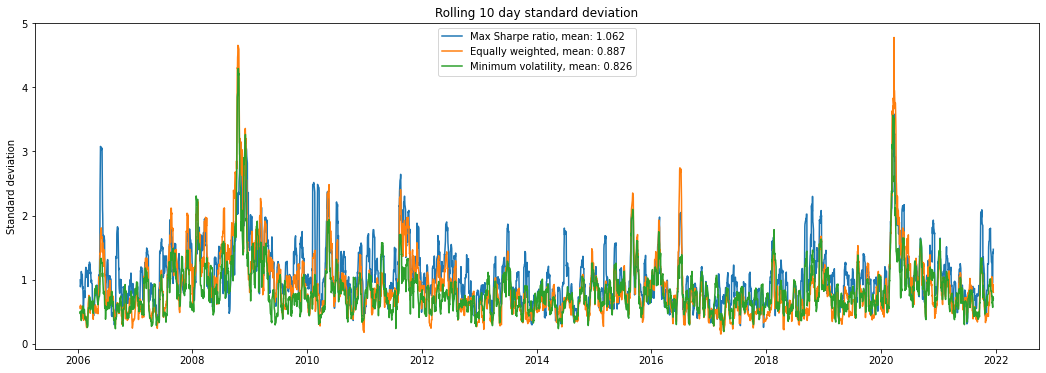

**Portfolio** | Description | Average 10 day standard deviation | Expected return
--- | :--- | :---: | :---: |
MaxSharpe |Maximum Sharpe (tangent portfolio) | 1.2005 | 0.085 |
EqualWeight |Equally weighted | 1.0619 | 0.0461 |
MinVol |Minimum volatility | 0.9475 | 0.0462 |
Hist |unoptimised | 1.1604 | 0.0322 |



# Data tests

In [5]:
minVol['loss'].describe()

count    3946.000000
mean       -0.044970
std         0.961238
min        -7.493037
25%        -0.584788
50%        -0.072185
75%         0.453015
max         7.475697
Name: loss, dtype: float64

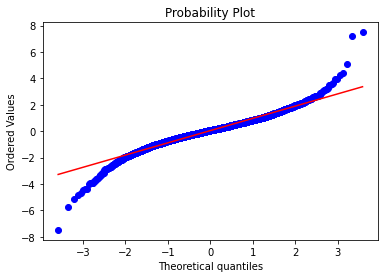

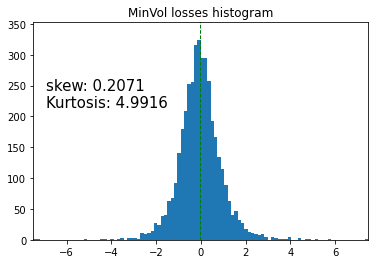

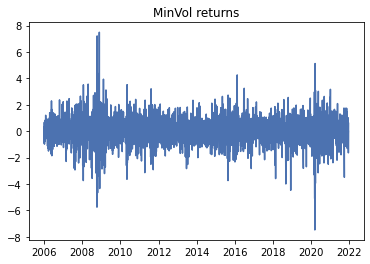

Data Tests
breusch pagan test

### Theoretical framework <a name="theory"></a>

# Value at risk

$VaR_{\alpha}(L)=inf\{l∈\mathbb{R}:F_{L}(l)≥\alpha\} = q_\alpha (F_L)\tag1$
<center>Where $F_L$  is the portfolio loss distribution.</center>

# Expected shortfall

$ES_\alpha\left(L\right)=\frac{1}{1-\alpha}\int^1_{\alpha}VaR_u(L)du\tag{2}$

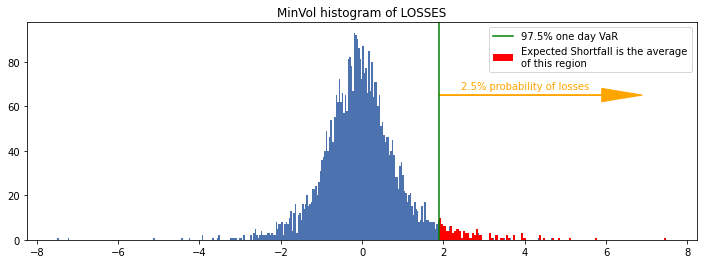

### Parametric method

##### Value at risk

$\large{\begin{split}\begin{equation*}
\begin{aligned}
G(z)&=\mathbb{P}[Z\leq z]=\mathbb{P}\left[\frac{L-\mu}{\sigma}\leq z\right]\\
&=\mathbb{P}[L\leq \sigma z + \mu]\\
&=F(\sigma z + \mu)
\end{aligned}
\end{equation*}\end{split}}
\tag9$

Denoting the ($a$) percentile of $L$ as $F(l_\alpha)$, and letting $z^*$ satisfy $l_\alpha = \sigma z^* + \mu$ in $(9)$, $z^*$ is the ($1-\alpha$) percentile of $L$:

$\large{\begin{split}\begin{equation*}
\begin{aligned}
G(z^*)&=F(\sigma z^* + \mu) = F(l_\alpha) = \alpha\\
&z^*=z_{\alpha} \Rightarrow l_\alpha = \mu + \sigma z_{\alpha}
\end{aligned}
\end{equation*}\end{split}}
\tag{10}$

Hence, the VaR for confidence level $\alpha$, where the standised loss random variable is assumed to be $Z\sim N(0,1)$, can be computed using:

$\large{VaR_{\alpha}(L)=\mu+z_{\alpha}\sigma}\tag{11}$


Where $Z$ is a standard normal innovation with zero mean and unit variance, the VaR estimates can be expessed as:

$\large{VaR_{\alpha}(L)=\mu+\sigma\Phi^{-1}(\alpha)}\tag{12}$
<center>    Where $\Phi^{-1}(\alpha)$  denotes the inverse of the standard normal distribution evaluated at $\alpha$.</center>

In models that utilise a short time frame, such as daily VaR, it would be reasonable to assume the mean of the returns should not deviate much from the zero, hence, the mean intecept is often removed from the model:

$$\large{VaR_{\alpha}(L)=\sigma\Phi^{-1}(\alpha)}\tag{13}$$


### Expected shortfall

$$
ES_\alpha(L)=V_t\left[\frac{\sigma}{1-\alpha}\phi(\Phi^{-1}(\alpha))\right]\tag{14}
$$


### Monte Carlo Simulation <a name="montecarlo"></a>
$\large{r_i=\mu\Delta t+\sigma \epsilon\sqrt{\Delta t}}\tag{11}$


The historical method 

# Parametric ES (A) <a name="parametric"></a>

$$\large{\begin{split}\begin{equation*}
\begin{aligned}
ES_{\alpha}(L)&=\frac{1}{1-\alpha}\int^1_{\alpha}VaR_u (L)\ du\\
ES_{\alpha}(L)&=\frac{1}{1-\alpha}\int^1_{\alpha}\mu +\sigma \Phi^{-1}(u)\ du \\
ES_{\alpha}(L)&=\mu + \frac{\sigma}{1-\alpha}\int^1_{\alpha}\Phi^{-1}(u)\ du \\
\end{aligned}
\end{equation*}\end{split}}$$

$\large{\text{Letting }x = \Phi^{-1}(u) \text{ and } \Phi(x)=u}$

$$
\large{𝑑𝑢 = 𝑑\Phi(𝑥)= \phi(𝑥)𝑑𝑥}\\
$$

$\large{\text{where: } \phi(x)=\frac{1}{\sqrt{2\pi} e^{-\frac{x^{2}}{2}}}}$

$$\large{\begin{split}\begin{equation*}
\begin{aligned}
ES_{\alpha}(L)&=\mu + \frac{\sigma}{1-\alpha}\int^{\infty }_{\Phi^{-1}}x\phi(x)\ dx \\\newline
ES_{\alpha}(L)&=\mu + \frac{\sigma}{1-\alpha}\int^{\infty }_{\Phi^{-1}}\frac{d}{dx}(-\phi(x))\ dx \\\newline
ES_{\alpha}(L)&=\mu + \frac{\sigma}{1-\alpha}\biggr[-\phi(\infty) + \phi(\Phi^{-1}(\alpha)) \biggr]\\\newline
ES_{\alpha}(L)&=\mu + \frac{\sigma}{1-\alpha}\phi(\Phi^{-1}(\alpha)) \\
\end{aligned}
\end{equation*}\end{split}}$$

# Exponentially Weighted Moving Average (EWMA) (B) <a name="EMWA"></a>

$$
\large{\sigma^2_{t+1}=\sum\limits{T}{\tau=1}w_{t+1-\tau}l^2_{}t+1-\tau}\tag{16}\\
\large{w_{t+1-\tau}=\frac{1-\lambda}{1-\lambda^T}\lambda^{\tau-1}},\qquad\qquad\lambda\in(0,1)
$$
\
\\
\



$$\sigma^2_{t+1}=\sum\limits^{T}_{t+1-\tau}l^{2}_{t+1-\tau}$$

$$\large{\begin{split}\begin{equation*}
\begin{aligned}
\sigma^2_{t+1} &= \underset{T\rightarrow \infty}{lim}\frac{(1-\lambda)}{1-\lambda^T}\sum\limits^{T}_{\tau=1}\lambda^{\tau-1}l^2_{t+1-\tau} \\\newline
\sigma^2_{t+1} &=\sum\limits^{\infty}_{\tau=1}\lambda^{\tau-1}l^2_{t+1-\tau} \\\newline
\sigma^2_{t+1} &=(1-\lambda)l^2_t + (1-\lambda) \sum\limits^{\infty}_{\tau=2}\lambda^{\tau-1}l^2_{t+1-\tau} \\\newline
\sigma^2_{t+1} &=(1-\lambda)l^2_t + (1-\lambda) \sum\limits^{\infty}_{\tau=1}\lambda^{\tau}l^2_{t-\tau} \\\newline
\sigma^2_{t+1} &=(1-\lambda)l^2_t + \lambda(1-\lambda) \sum\limits^{\infty}_{\tau=1}\lambda^{\tau-1}l^2_{t-\tau} \\\newline
\sigma_{t+1} &=\sqrt{(1-\lambda)l^2_t + \lambda(\sigma^2_t)} \\\newline
\end{aligned}
\end{equation*}\end{split}}$$

# ARCH <a name="ARCH"></a>

The Autoregressive Conditional Heteroskedasticity (ARCH) model\
\
$$
\large{\begin{eqnarray}
\sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_{t-1}
\end{eqnarray}}\tag{17}
$$
\

$$\large{\large{\begin{split}\begin{equation*}
\begin{aligned}
y_t-\mu&=\phi_1(y_{t-1}-\mu)+\cdot\cdot\cdot +\phi_n(y_{t-n}-\mu)+\epsilon_t\\\newline
\text{Or equivalently:}\\\newline
y_t&=\mu+\sum\limits_{i=1}^{n}\phi_iy_{t-i}+\epsilon_t
\end{aligned}
\end{equation*}\end{split}}}$$

/

When forecasting the variance, conditional on previous lags:


$$\large{\text{Var}(y_t | y_{t-1}) = \sigma^2_t = \alpha_0 + \alpha_1 y^2_{t-1}}\tag{17}$$
If the series has mean=0, the ARCH model can be denoted as:
$$
\large{y_t = \sigma_t \epsilon_t,\\
\sigma_t = \sqrt{\alpha_0 + \alpha_1y^2_{t-1}},\\
\epsilon_t \overset{iid}{\sim} (\mu=0,\sigma^2=1)}
$$

$$
\large{\begin{eqnarray}
\epsilon_t = w_t \sqrt{\alpha_0 + \sum^p_{i=1} \alpha_p \epsilon^2_{t-i}}
\end{eqnarray}}\tag{17}
$$

# GARCH <a name="GARCH"></a>
$$
\large{\begin{eqnarray}
\sigma^2_t = \alpha_0 + \sum^{q}_{i=1} \alpha_i \epsilon^2_{t-i} + \sum^{p}_{j=1} \beta_j \sigma^2_{t-j}
\end{eqnarray}}\tag{18}
$$\
\
\
\
\
\
\
\
$$
\large{\begin{split}\begin{equation*}
\begin{aligned}
l_t &= \sigma_tZ_t, \qquad Z_t\sim N(0,1) \\\newline
\sigma^2_{t+1} &= \gamma\bar{\sigma}^2 + \alpha l^2_t + \beta\sigma^2_t\\\newline
\end{aligned}
\end{equation*}\end{split}}
$$

$\large{\text{Where } \gamma = 1 - (\alpha + \beta) \text{ and the long run variance, }\bar\sigma^2 = \frac{w}{1-(\alpha+\beta)}}$

$$
\large{\begin{split}\begin{equation*}
\begin{aligned}
k &= \mathbb{E}\left[l^4_t\right]\quad \forall\quad t\\\newline
k &= \mathbb{E}\left[\sigma^4_{t+1}\right]\mathbb{E}\left[Z^4_{t+1}\right]
\end{aligned}
\end{equation*}\end{split}}
$$

$\large{\text{Since } Z_t \sim N(0,1)},$

$$
\large{\begin{split}\begin{equation*}
\begin{aligned}
k &= 3 \mathbb{E}\left[\sigma^4_{t+1}\right] \\\newline
k &= 3 \mathbb{E}\left[\left(\sigma^2_{t+1}\right)^2\right] \\\newline
\end{aligned}
\end{equation*}\end{split}}
$$

$\large{\text{Using GARCH (1,1) model for } \sigma^2_{t+1}}:$

$$
\large{\begin{split}\begin{equation*}
\begin{aligned}
k &= 3\mathbb{E}\left[\left(w+\alpha l^2_t + \beta \sigma^2_t\right)^2\right] \\\newline
k &= 3\mathbb{E}\left[w^2+\alpha^2l^4_t+\beta^2\sigma^4_t+2w\alpha l^2_t + ... + 2w\beta\sigma^2_t+2\alpha\beta\sigma^4_tZ^2_t\right] \\\newline
\text{Since: }\quad\mathbb{E}\left[l^4_t\right]&=k\text{ and }\mathbb{E}\left[\sigma^4_{t+1}\right]=\frac{k}{3}\\\newline
\text{and letting: }\quad\mathbb{E}\left[l^2_t\right]&=\mathbb{E}\left[\sigma^2_t\right]=\sigma^2=\bar\sigma^2\\
\\
k&=3\left[w^2+2w(\alpha+\beta)\bar\sigma^2+k\left(\alpha^2+\frac{\beta^2+2\alpha\beta}{3}\right)\right]\\
\\
k&=k\left[3\alpha^2+\beta^2+2\alpha\beta\right]+3\left(w^2+2w\biggr(\alpha+\beta\biggr)\frac{w}{1-(\alpha+\beta)}\right)\\
\\
k&=k\left[2\alpha^2+(\alpha+\beta)^2\right]+3w^2\frac{(1+(\alpha+\beta))}{(1-(\alpha+\beta))}\\
\\
k&=k\left[2\alpha^2+(\alpha+\beta)^2\right]+3w^2\frac{(1+(\alpha+\beta)^2)}{(1-(\alpha+\beta))^2}\\
\\
k&=k\left[2\alpha^2+(\alpha+\beta)^2\right]+3\sigma^4(1-(\alpha+\beta)^2)\\
\\
\frac{k}{\sigma^4}&=3\left[\frac{1-(\alpha+\beta)^2}{1-(\alpha+\beta)^2 - 2\alpha^2}\right]>3\\
\\
\end{aligned}
\end{equation*}\end{split}}
$$

$\large{\text{Hence kurtosis >3 where }(\alpha+\beta)^2<1-2\alpha^2}$

# EGARCH <a name="EGARCH"></a>
$$
\large{\ln\sigma_t^2 = \alpha_o + \sum_{i=1}^p {\alpha_i \left(\left|\epsilon_{t-i}\right|+\gamma_i\epsilon_{t-i}\right )}+\sum_{j=1}^q{\beta_j \ln\sigma_{t-j}^2}}\tag{19}
$$

# Error rate

The number of breaches is useful to understand the efficacy of the model but the oversimplified metric fails to reveal the accuracy.  

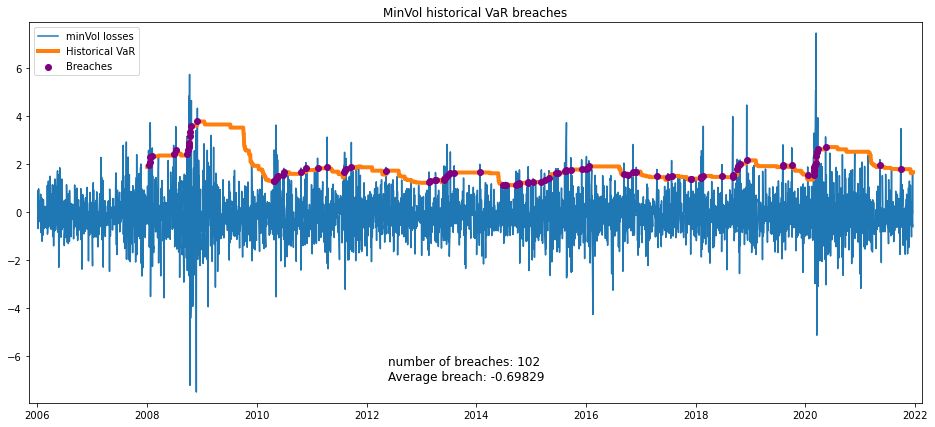

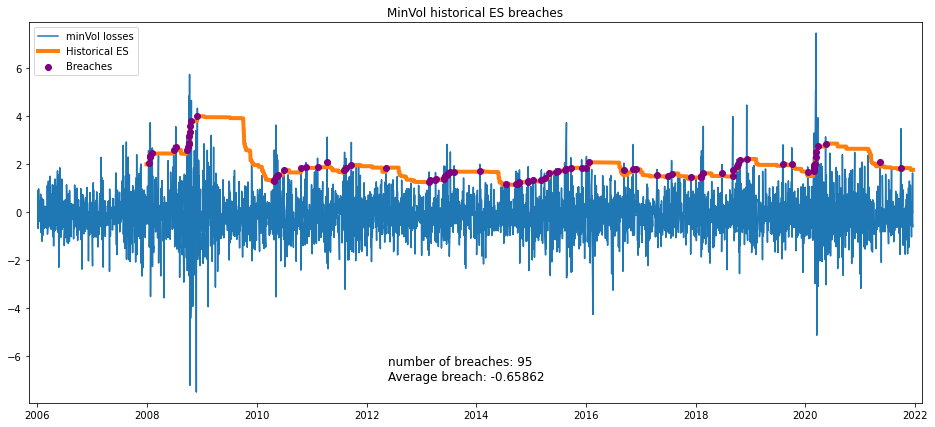



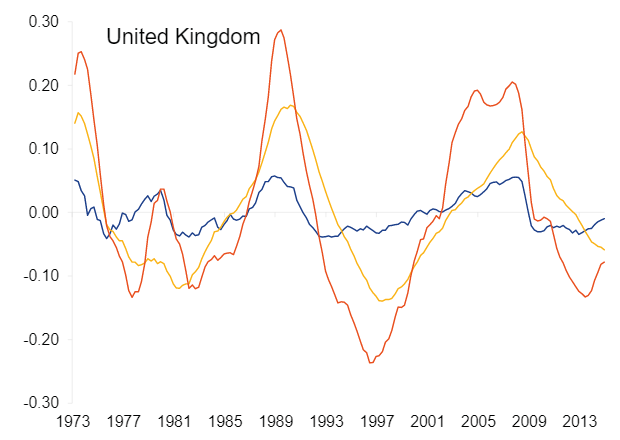 [link](https://www.ecb.europa.eu/pub/economic-research/resbull/2016/html/rb160831.en.html)

ECB identified that theres a downturn in every decade (black swan events)

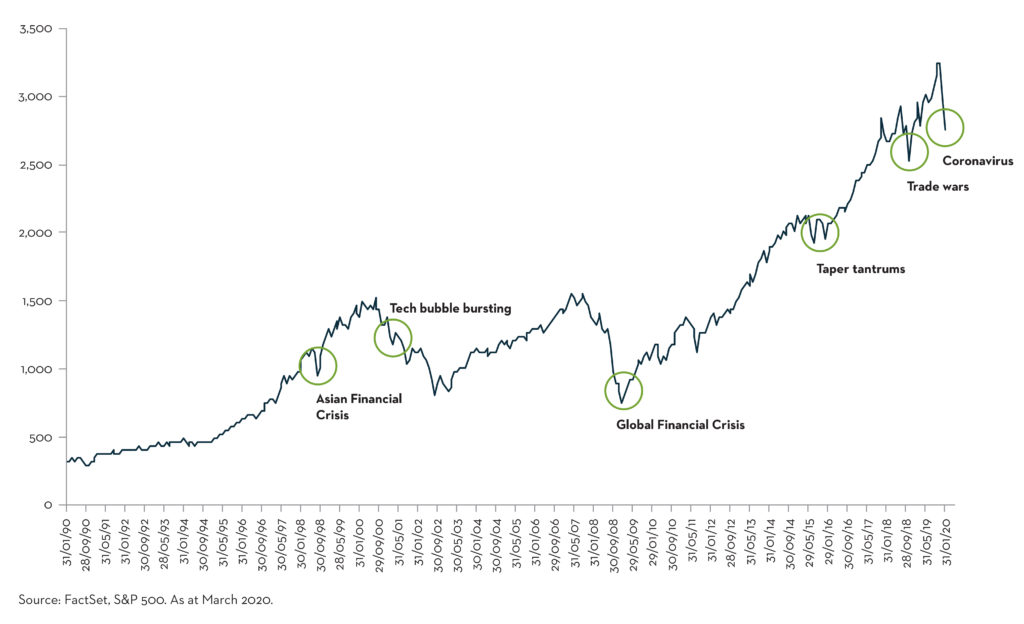 [link](https://embarkgroup.co.uk/insights/black-swan-time-for-a-long-term-perspective/)


### Backtest <a name="backtest"></a>

https://www.msci.com/documents/1296102/1636401/risk1214msci.pdf/b2e0992f-bdbf-432f-97ef-a679630e8e8f

##### GARCH - 1 step
number of breaches: 102
Average breach: -0.6495089073583336

##### GARCH - 2 step
number of breaches: 121
Average breach: -0.6516605472816375

##### GARCH - 3 step
number of breaches: 136
Average breach: -0.6619022387727868

# Appendix <a name="appendix"></a>

**Appendix A.**
*Some FTSE100 tickers were replaced with:*

Ticker | Start date | Replacement
--- | --- | :---: |
PSN | 2019-05-08 | JMAT.L
PSH.L | 2017-03-10 | LIN
AAF.L | 2019-06-28 | INVR.L
MNG.L | 2019-10-21 | AON
AVST.L| 2018-05-10 | PNR
HLN.L | 2022-07-18 | ITV.L
HBR.L | 2021-04-01 | RMG.L

**Appendix B.**
*The tickers of the all the assets used and their full name:*

Ticker | Name | | Ticker | Name | | Ticker | Name |
:--- | :--- |:--- | :--- | :--- |:--- | :--- | :--- |
HWDN.L  |  HOWDEN JOINERY GROUP PLC |  | SKG.L  |  SMURFIT KAPPA GROUP PLC |  | SBRY.L  |  SAINSBURY(J) PLC
III  |  3I GROUP PLC |  | BRBY.L  |  BURBERRY GROUP PLC |  | RIO  |  RIO TINTO PLC
SPX.L  |  SPIRAX-SARCO ENGINEERING PLC |  | LSEG.L  |  LONDON STOCK EXCHANGE GROUP PLC |  | FLTR  |  FLUTTER ENTERTAINMENT PLC
ICP.L  |  INTERMEDIATE CAPITAL GROUP PLC |  | NXT.L  |  NEXT PLC |  | EDV  |  ENDEAVOUR MINING PLC
ITV.L  |  ITV PLC |  | AV.L  |  AVIVA PLC |  | MRO  |  MELROSE INDUSTRIES PLC
HLMA.L  |  HALMA PLC |  | HSBA.L  |  HSBC HLDGS PLC |  | ULVR.L  |  UNILEVER PLC
TW.L  |  TAYLOR WIMPEY PLC |  | DGE.L  |  DIAGEO PLC |  | DCC.L  |  DCC PLC
ITRK.L  |  INTERTEK GROUP PLC |  | BME  |  B&M EUROPEAN VALUE RETAIL S.A. (DI) |  | CPG  |  COMPASS GROUP PLC
EXPN.L  |  EXPERIAN PLC |  | UTG  |  UNITE GROUP PLC |  | ANTO.L  |  ANTOFAGASTA PLC
RS1.L  |  RS GROUP PLC |  | AAL  |  ANGLO AMERICAN PLC |  | ADM  |  ADMIRAL GROUP PLC
BDEV.L  |  BARRATT DEVELOPMENTS PLC |  | PHNX.L  |  PHOENIX GROUP HOLDINGS PLC |  | MGGT.L  |  MEGGITT PLC
CRDA.L  |  CRODA INTERNATIONAL PLC |  | BARC.L  |  BARCLAYS PLC |  | LLOY.L  |  LLOYDS BANKING GROUP PLC
JMAT.L  |  JOHNSON MATTHEY PLC |  | BT-A.L  |  BT GROUP PLC |  | PRU  |  PRUDENTIAL PLC
AUTO  |  AUTO TRADER GROUP PLC |  | ABF.L  |  ASSOCIATED BRITISH FOODS PLC |  | ENT.L  |  ENTAIN PLC
STJ.L  |  ST.JAMES'S PLACE PLC |  | LIN  |  LINDE PLC |  | BATS.L  |  BRITISH AMERICAN TOBACCO PLC
RMV.L  |  RIGHTMOVE PLC |  | MNDI.L  |  MONDI PLC |  | RKT.L  |  RECKITT BENCKISER GROUP PLC
HL.L  |  HARGREAVES LANSDOWN PLC |  | NWG  |  NATWEST GROUP PLC |  | CNA  |  CENTRICA PLC
SN.L  |  SMITH & NEPHEW PLC |  | CCH.L  |  COCA-COLA HBC AG |  | FRES.L  |  FRESNILLO PLC
HIK.L  |  HIKMA PHARMACEUTICALS PLC |  | RTO.L  |  RENTOKIL INITIAL PLC |  | IHG  |  INTERCONTINENTAL HOTELS GROUP PLC
AVV.L  |  AVEVA GROUP PLC |  | KGF.L  |  KINGFISHER PLC |  | WTB.L  |  WHITBREAD PLC
JD.L  |  JD SPORTS FASHION PLC |  | PSON.L  |  PEARSON PLC |  | SHEL  |  SHELL PLC
BKG.L  |  BERKELEY GROUP HOLDINGS (THE) PLC |  | CRH  |  CRH PLC |  | AZN  |  ASTRAZENECA PLC
WPP  |  WPP PLC |  | TSCO  |  TESCO PLC |  | BP.L  |  BP PLC
BNZL.L  |  BUNZL PLC |  | SVT  |  SEVERN TRENT PLC |  | GLEN.L  |  GLENCORE PLC
SGE.L  |  SAGE GROUP PLC |  | INVR.L  |  INVESTEC PLC |  | GSK  |  GSK PLC
ABDN.L  |  ABRDN PLC |  | BLND.L  |  BRITISH LAND CO PLC |  | NG.L  |  NATIONAL GRID PLC
SMIN  |  SMITHS GROUP PLC |  | STAN.L  |  STANDARD CHARTERED PLC |  | IAG  |  INTL CONSOLIDATED AIRLINES GROUP SA
LGEN.L  |  LEGAL & GENERAL GROUP PLC |  | SMDS.L  |  SMITH (DS) PLC |  | SSE.L  |  SSE PLC
SDR.L  |  SCHRODERS PLC |  | AON  |  AON PLC |  | BA.L  |  BAE SYSTEMS PLC
AHT  |  ASHTEAD GROUP PLC |  | RR.L  |  ROLLS-ROYCE HOLDINGS PLC |  | OCDO.L  |  OCADO GROUP PLC
REL.L  |  RELX PLC |  | INF.L  |  INFORMA PLC |  | PNR  |  AVAST PLC
SMT.L  |  SCOTTISH MORTGAGE INV TST PLC |  | UU.L  |  UNITED UTILITIES GROUP PLC |  | DPH.L  |  DECHRA PHARMACEUTICALS PLC
SGRO.L  |  SEGRO PLC |  | IMB.L  |  IMPERIAL BRANDS PLC |  | RMG.L  |  HARBOUR ENERGY PLC
LAND  |  LAND SECURITIES GROUP PLC |  | VOD  |  VODAFONE GROUP PLC |  |  | 
